In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# خواندن دیتا ها
!unzip "/content/drive/MyDrive/Project/Dataset/train.zip" -d "/content/train"
!unzip "/content/drive/MyDrive/Project/Dataset/validation.zip" -d "/content/validation"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/test/night (3124).jpg  
  inflating: /content/train/test/night (3124).xml  
  inflating: /content/train/test/night (3125).jpg  
  inflating: /content/train/test/night (3125).xml  
  inflating: /content/train/test/night (3126).jpg  
  inflating: /content/train/test/night (3126).xml  
  inflating: /content/train/test/night (3127).jpg  
  inflating: /content/train/test/night (3127).xml  
  inflating: /content/train/test/night (3128).jpg  
  inflating: /content/train/test/night (3128).xml  
  inflating: /content/train/test/night (3129).jpg  
  inflating: /content/train/test/night (3129).xml  
  inflating: /content/train/test/night (3130).jpg  
  inflating: /content/train/test/night (3130).xml  
  inflating: /content/train/test/night (3131).jpg  
  inflating: /content/train/test/night (3131).xml  
  inflating: /content/train/test/night (3132).jpg  
  inflating: /content/train/test/night (3132).xml  
  inflating: 

In [3]:
# مسیر استخراج فایل‌ها
train_dir = "/content/train/train"
validation_dir = "/content/validation/validation"

In [5]:
# نمایش محتویات پوشه‌های train و validation
print("Train files:", os.listdir(train_dir)[:10])  # نمایش 10 فایل اول
print("Validation files:", os.listdir(validation_dir)[:10])

Train files: ['day_02421.xml', 'night (910).jpg', 'night (4039).xml', 'day_16712.jpg', 'day_10554.jpg', 'night (1497).jpg', 'day_00482.jpg', 'day_06594.jpg', 'day_14535.jpg', 'day_07657.xml']
Validation files: ['night (725).jpg', 'night (1552).jpg', 'day_09419.xml', 'day_02425.xml', 'day_12425.jpg', 'day_03167.jpg', 'day_15638.jpg', 'day_06796.xml', 'day_07821.xml', 'day_15613.xml']


In [6]:
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET

In [7]:
def remove_night_images(directory):
    """
    حذف تصاویر و فایل‌های XML مربوط به شب اونهایی که اسم فایل با night شروع میشن .
    """
    files = os.listdir(directory)
    for file in files:
        if file.startswith('night'):
            file_path = os.path.join(directory, file)
            os.remove(file_path)  # حذف فایل

# حذف تصاویر شب از پوشه‌های train و validation
remove_night_images(train_dir)
remove_night_images(validation_dir)

# بررسی مجدد پوشه‌ها پس از حذف تصاویر شب
print("Remaining train files:", os.listdir(train_dir)[:10])
print("Remaining validation files:", os.listdir(validation_dir)[:10])


Remaining train files: ['day_02421.xml', 'day_16712.jpg', 'day_10554.jpg', 'day_00482.jpg', 'day_06594.jpg', 'day_14535.jpg', 'day_07657.xml', 'day_08847.jpg', 'day_15977.xml', 'day_12528.jpg']
Remaining validation files: ['day_09419.xml', 'day_02425.xml', 'day_12425.jpg', 'day_03167.jpg', 'day_15638.jpg', 'day_06796.xml', 'day_07821.xml', 'day_15613.xml', 'day_15192.jpg', 'day_05042.jpg']


In [8]:
def parse_xml_file(xml_path):
    """
    یک فایل XML را خوانده و مختصات پلاک خودرو را برمی‌گرداند.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # استخراج مختصات پلاک خودرو
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        return (xmin, ymin, xmax, ymax)

# نمایش یک فایل XML برای مثال
xml_sample = os.path.join(train_dir, 'day_00010.xml')  # جایگزین با یک فایل XML موجود
bbox = parse_xml_file(xml_sample)
print("Bounding box for sample:", bbox)


Bounding box for sample: (850, 383, 906, 402)


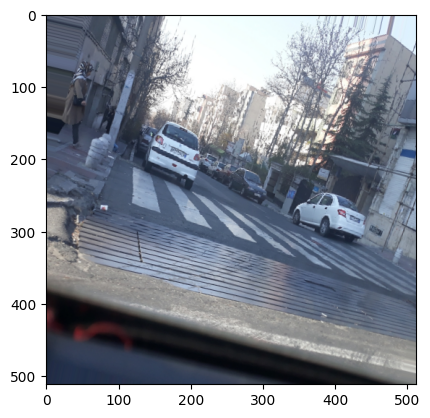

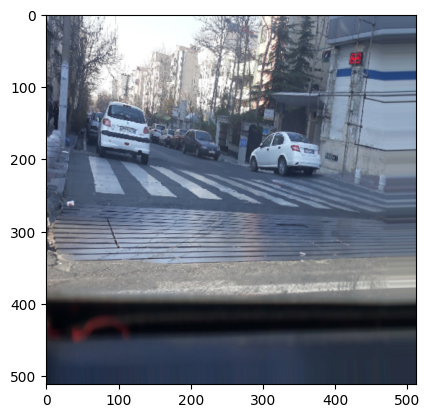

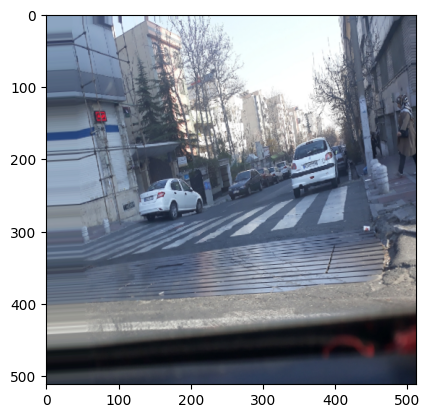

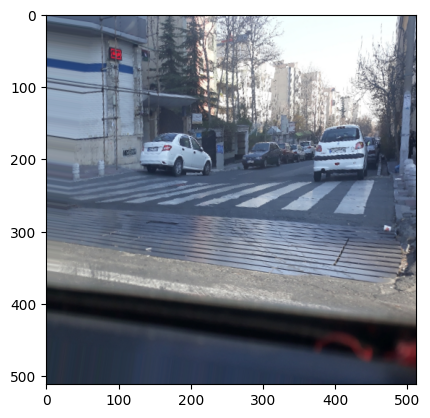

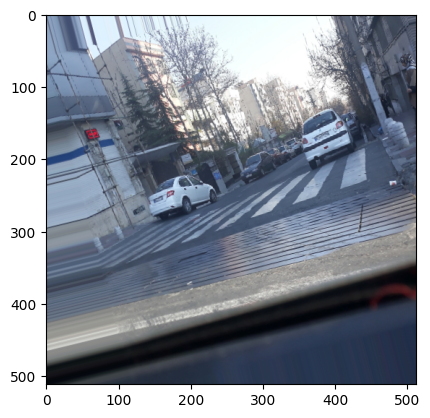

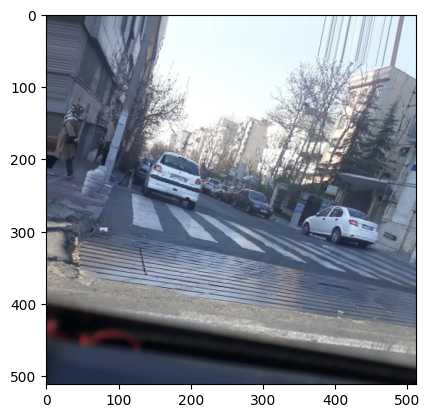

In [9]:
# تعریف تکنیک‌های داده‌افزایی
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# بارگذاری یک تصویر برای تست داده‌افزایی
img_path = os.path.join(train_dir, 'day_00010.jpg')  # جایگزین با یک فایل jpg موجود
img = image.load_img(img_path, target_size=(512, 512))  # تنظیم ابعاد تصویر

# تبدیل تصویر به آرایه
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# تولید و نمایش تصاویر افزوده‌شده
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.show()

    i += 1
    if i > 5:  # نمایش 5 نمونه
        break


In [10]:
def resize_images(directory, target_size=(512, 512)):
    """
    تغییر اندازه تمامی تصاویر موجود در دایرکتوری به اندازه مشخص.
    """
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.png'):  # فرض می‌کنیم تصاویر فرمت PNG دارند
            img_path = os.path.join(directory, file)
            img = Image.open(img_path)
            img = img.resize(target_size)
            img.save(img_path)

# تغییر اندازه تصاویر train و validation به اندازه  512 x 512
resize_images(train_dir, target_size=(512, 512))
resize_images(validation_dir, target_size=(512, 512))

print("Images resized to 512x512.")


Images resized to 512x512.


In [11]:
def move_images_to_class_dir(source_dir, target_dir, class_name='car_images'):
    class_dir = os.path.join(target_dir, class_name)

    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    for filename in os.listdir(source_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            shutil.move(os.path.join(source_dir, filename), os.path.join(class_dir, filename))

# انتقال تصاویر به پوشه دسته‌بندی فرضی
move_images_to_class_dir(train_dir, train_dir)
move_images_to_class_dir(validation_dir, validation_dir)


In [23]:
# تنظیم seed برای تکرارپذیری نتایج
seed = 42

# تعریف داده‌افزایی
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

tf.random.set_seed(seed)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 3351 images belonging to 1 classes.
Found 1708 images belonging to 1 classes.


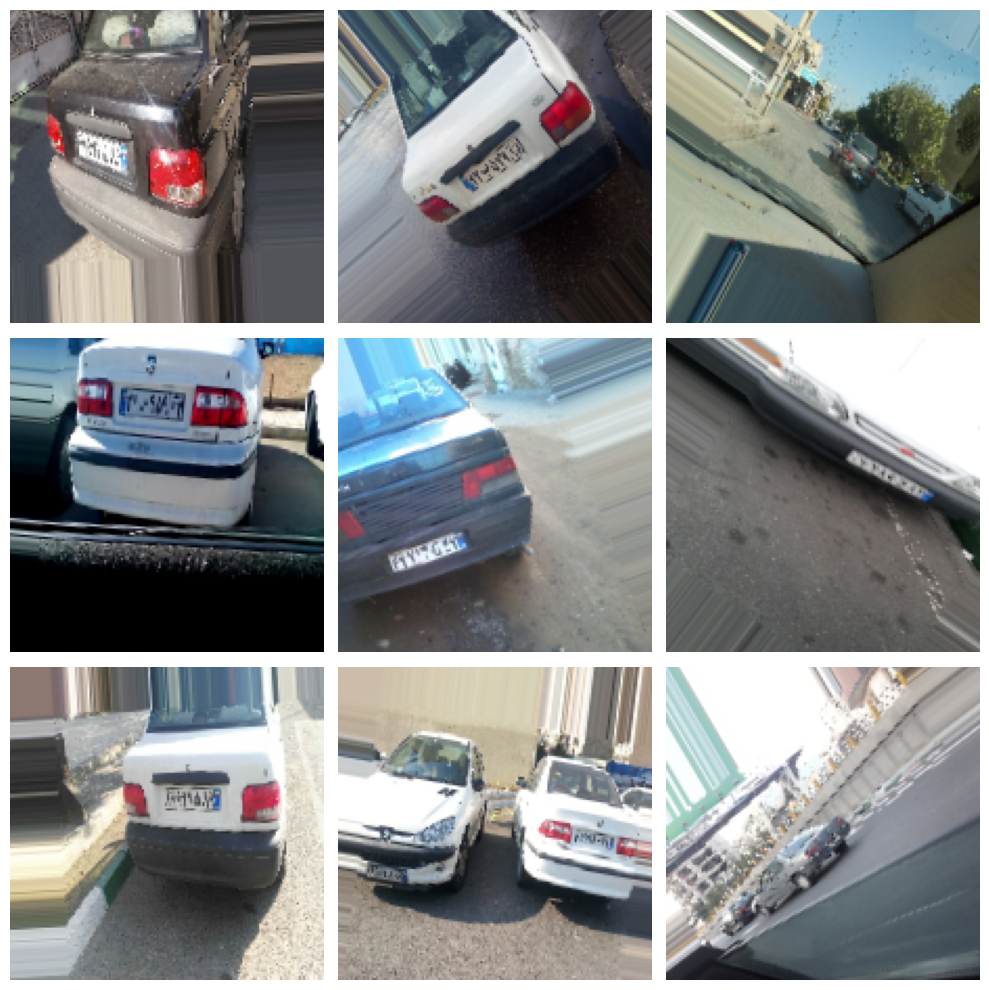

In [25]:
def plot_augmented_images(generator, num_images=9, save=False):
    x_batch, y_batch = generator.__next__()

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(num_images):
        ax = axes.flat[i]
        ax.imshow(x_batch[i])
        ax.axis('off')

    plt.tight_layout()
    if save:
        plt.savefig('augmented_images.png')
    plt.show()

# نمایش تصاویر تقویت شده با ذخیره کردن
plot_augmented_images(train_generator, save=True)